<a href="https://colab.research.google.com/github/CharlesCoster/ada-project-terrorism-impact/blob/master/pre_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#1. Tourism

In [0]:
import pandas as pd

df_tourism = pd.read_csv('tourism.csv',sep='\t')

In [0]:
# Keep data in national currency and only exporta and import total tourism values
df_tourism = df_tourism[df_tourism.VAR.isin(['EXPORT_TOTAL','IMPORT_TOTAL'])&df_tourism.CUR.isin(['NAT'])]

# Compute increase since last year
df_tourism['Growth'] = df_tourism.groupby(['COUNTRY','VAR']).Value.pct_change()
df_tourism = df_tourism[['COUNTRY','VAR','YEAR','Growth']]
df_tourism.columns=['country_code','tourism_var','year','tourism_growth']
df_tourism.head()

,country_code,tourism_var,year,tourism_growth
0,AUS,EXPORT_TOTAL,2008,NaN
1,AUS,EXPORT_TOTAL,2009,0.034807
2,AUS,EXPORT_TOTAL,2010,-0.002731
3,AUS,EXPORT_TOTAL,2011,-0.021077
4,AUS,EXPORT_TOTAL,2012,-0.021957


In [0]:
df_tourism.set_index(['country_code','year'],inplace=True)
df_tourism = df_tourism.pivot_table(index=df_tourism.index,columns='tourism_var',values='tourism_growth')
df_tourism.reset_index(inplace=True)
df_tourism.head()

tourism_var,index,EXPORT_TOTAL,IMPORT_TOTAL
0,"(AUS, 2009)",0.034807,-0.002004
1,"(AUS, 2010)",-0.002731,0.058791
2,"(AUS, 2011)",-0.021077,0.097287
3,"(AUS, 2012)",-0.021957,0.053171
4,"(AUS, 2013)",0.043211,0.093014


In [0]:
df_tourism.columns=['country_year','growth_export_tourism','growth_import_tourism']
df_tourism['country_code'] = df_tourism.country_year.apply(lambda x:x[0])
df_tourism['year'] = df_tourism.country_year.apply(lambda x:x[1])
df_tourism.drop('country_year',axis=1,inplace=True)
df_tourism.head()

,growth_export_tourism,growth_import_tourism,country_code,year
0,0.034807,-0.002004,AUS,2009
1,-0.002731,0.058791,AUS,2010
2,-0.021077,0.097287,AUS,2011
3,-0.021957,0.053171,AUS,2012
4,0.043211,0.093014,AUS,2013


In [0]:
df_tourism.to_csv('final_tourism.csv')

# Better tourism dataset

In [132]:
tourism = pd.read_csv('https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/data/international-tourism-number-of-arrivals.csv')
tourism.drop('Entity',axis=1,inplace=True)
tourism.columns = ['country_code','iyear','num_arrivals']
tourism.head()

,country_code,iyear,num_arrivals
0,ALB,1995,304000.0
1,ALB,1996,287000.0
2,ALB,1997,119000.0
3,ALB,1998,184000.0
4,ALB,1999,371000.0


#2. Terrorism

In [0]:
# We import dblp from google drive
id='1bfZzGpT5jQwYuLHfdgPO_4JSLyPsIVBR'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('globalterrorismdb_0919dist.xlsx')  
dblp = pd.read_excel('globalterrorismdb_0919dist.xlsx',index_col='eventid')

In [15]:
dblp.head()

,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,...,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
eventid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,Central America & Caribbean,National,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,...,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,...,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,...,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
197001000003,1970,1,0,NaN,0,NaT,101,Japan,4,East Asia,Fukouka,Fukouka,33.580412,130.396361,1.0,0,NaN,NaN,1,1,1,-9,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Consulate,217.0,...,NaN,NaN,Incendiary,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [0]:
# Keep only datas with political social economical or social goal, with intention to coerce,... and outsie international humanitarian law
terrorism = dblp[dblp.crit1.isin([1])&dblp.crit2.isin([1])&dblp.crit3.isin([1])]

# Keep variabls of interest
features_col = ['iyear','imonth','iday','country_txt','city','region_txt','attacktype1_txt','attacktype2_txt','attacktype3_txt',
                'targtype1_txt','targtype2_txt','weaptype1_txt','weaptype2_txt','weaptype3_txt','weaptype4_txt','gname',
                'nkill','nkillter']
              
terrorism = terrorism[features_col]

In [244]:
countries = pd.read_csv('https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/data/country_code.csv',encoding='latin')
countries.columns=['country_txt','country_code']
countries.head()

,country_txt,country_code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,AND


In [0]:
# Get data per year and per countries
terrorism = terrorism.merge(countries,on='country_txt',how='left')

In [246]:
# Get number of attacks per year and per country
kills = terrorism.groupby(['country_code','iyear']).nkill.sum().to_frame()
kills.columns = ['kills']
killster = terrorism.groupby(['country_code','iyear']).nkillter.sum().to_frame()
killster.columns = ['killster']
nattacks = terrorism.groupby(['country_code','iyear']).size().to_frame()
nattacks.columns = ['nattacks']
terr1_df = kills.merge(killster,left_index=True, right_index=True).merge(nattacks,left_index=True, right_index=True)
terr1_df.reset_index(inplace=True)
terr1_df.head()

,country_code,iyear,kills,killster,nattacks
0,AFG,1973,0.0,0.0,1
1,AFG,1979,53.0,0.0,3
2,AFG,1987,0.0,0.0,1
3,AFG,1988,124.0,0.0,10
4,AFG,1989,10.0,0.0,10


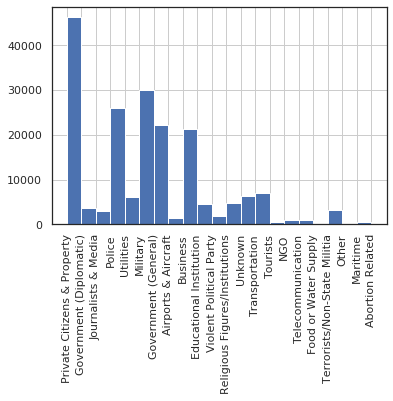

In [247]:
dblp.targtype1_txt.hist(bins=21,xrot=90)

In [0]:
# Get number of target types per year
dict_targets = {}
for (country, year), group in terrorism.groupby(['country_code','iyear']):
  dict_targets[year,country] = {}
  for txt in ['targtype1_txt','targtype2_txt']:
    targets = group[txt].value_counts().to_dict()
    for tar in targets.keys():
      if tar in ['Private Citizens & Property','Government (General)','Military'] and tar in dict_targets[year,country]:
        dict_targets[year,country][tar] += targets[tar]
      elif tar in ['Private Citizens & Property','Government (General)','Military']:
        dict_targets[year,country][tar] = targets[tar]

In [249]:
target_df = pd.DataFrame.from_dict(dict_targets,orient='index')
target_df.fillna(0,inplace=True)

target_df.head()

,,Private Citizens & Property,Government (General),Military
1987,AFG,1.0,0.0,0.0
1988,AFG,7.0,0.0,0.0
1989,AFG,4.0,0.0,0.0
1991,AFG,15.0,2.0,0.0
1992,AFG,2.0,11.0,0.0


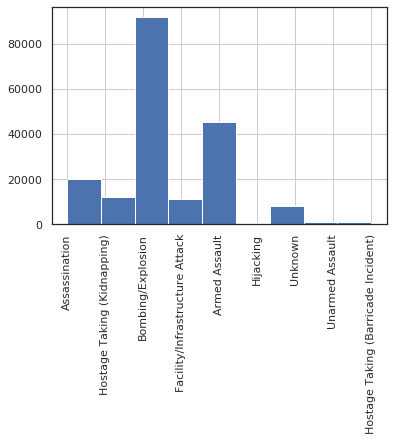

In [250]:
dblp.attacktype1_txt.hist(bins=9,xrot=90)

In [0]:
dict_attacks = {}
for (country, year), group in terrorism.groupby(['country_code','iyear']):
  dict_attacks[year,country] = {}
  for txt in ['attacktype1_txt','attacktype2_txt','attacktype3_txt']:
    attacks = group[txt].value_counts().to_dict()
    for att in attacks.keys():
      if att in ['Bombing/Explosion','Armed Assault'] and att in dict_attacks[year,country]:
        dict_attacks[year,country][att] += attacks[att]
      elif att in ['Bombing/Explosion','Armed Assault']:
        dict_attacks[year,country][att] = attacks[att]

In [252]:
attack_df = pd.DataFrame.from_dict(dict_attacks,orient='index')
attack_df.fillna(0,inplace=True)

attack_df.head()

,,Armed Assault,Bombing/Explosion
1979,AFG,1.0,1.0
1991,AFG,1.0,20.0
1992,AFG,2.0,12.0
1996,AFG,1.0,2.0
2000,AFG,1.0,12.0


In [253]:
terr2_df = attack_df.merge(target_df,left_index=True,right_index=True,how='outer')
terr2_df.index.levels[0].name = 'iyear'
terr2_df.index.levels[1].name = 'country_code'
terr2_df.rename({'Armed Assault':'armed_assault_type',
                 'Bombing/Explosion':'bomb_exp_type',
                 'Private Citizens & Property':'cit_tar',
                 'Government (General)':'gov_tar',
                 'Military':'mil_tar'},axis=1,inplace=True)
terr2_df.reset_index(inplace=True)
terr2_df.head()

,iyear,country_code,armed_assault_type,bomb_exp_type,cit_tar,gov_tar,mil_tar
0,1970,ARG,7.0,4.0,4.0,5.0,1.0
1,1970,AUS,0.0,1.0,NaN,NaN,NaN
2,1970,BEL,0.0,1.0,NaN,NaN,NaN
3,1970,BRD,5.0,5.0,1.0,6.0,0.0
4,1970,CAN,NaN,NaN,0.0,2.0,0.0


In [254]:
terrorism = terr1_df.merge(terr2_df,how='outer')
terrorism.head()

,country_code,iyear,kills,killster,nattacks,armed_assault_type,bomb_exp_type,cit_tar,gov_tar,mil_tar
0,AFG,1973,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN
1,AFG,1979,53.0,0.0,3,1.0,1.0,NaN,NaN,NaN
2,AFG,1987,0.0,0.0,1,NaN,NaN,1.0,0.0,0.0
3,AFG,1988,124.0,0.0,10,0.0,10.0,7.0,0.0,0.0
4,AFG,1989,10.0,0.0,10,0.0,9.0,4.0,0.0,0.0


In [255]:
terrorism.describe()

,iyear,kills,killster,nattacks,armed_assault_type,bomb_exp_type,cit_tar,gov_tar,mil_tar
count,3631.000000,3631.000000,3631.000000,3631.000000,3068.000000,3068.000000,2771.000000,2771.000000,2771.000000
mean,1996.589645,90.909942,11.156982,44.314789,11.651565,26.579531,17.867196,8.050884,2.369542
std,13.247990,473.643822,115.353906,161.513122,38.529273,114.090934,72.758115,22.933571,10.115856
min,1970.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1986.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1996.000000,2.000000,0.000000,5.000000,1.000000,3.000000,2.000000,1.000000,0.000000
75%,2008.000000,22.000000,0.000000,22.000000,5.000000,13.000000,9.000000,5.000000,1.000000
max,2018.000000,10744.000000,3305.000000,3380.000000,552.000000,2552.000000,1544.000000,288.000000,193.000000


# Politic

In [0]:
cpds = pd.read_excel('http://www.cpds-data.org/images/Update2019/CPDS-1960-2017-Update-2019.xlsx', parse_dates=True)

In [0]:
politic = cpds[['year','iso']].copy()
politic.columns = ['iyear','country_code']

In [258]:
politic['elec_leftsoc'] = cpds['leftsoc1']+cpds['leftsoc2']+cpds['leftsoc3']+cpds['leftsoc4']+cpds['leftsoc5']
politic['elec_comm'] = cpds['comm1']+cpds['comm2']+cpds['comm3']+cpds['comm4']
politic['elec_conserv'] = cpds['conserv1']+cpds['conserv2']+cpds['conserv3']+cpds['conserv4']+cpds['conserv5']+cpds['conserv6']+cpds['conserv7']+cpds['conserv8']
politic['elec_right'] = cpds['right1']+cpds['right2']+cpds['right3']+cpds['right4']+cpds['right5']+cpds['right6']
politic['turnout'] = cpds['vturn']
politic.head()

,iyear,country_code,elec_leftsoc,elec_comm,elec_conserv,elec_right,turnout
0,1960,AUS,0.0,0.0,37.2,0.0,95.5
1,1961,AUS,0.0,0.0,33.6,0.0,95.3
2,1962,AUS,0.0,0.0,33.6,0.0,95.3
3,1963,AUS,0.0,0.0,37.1,0.0,95.7
4,1964,AUS,0.0,0.0,37.1,0.0,95.7


In [0]:
#df_politic['left_soc_inc'] = df_politic.groupby(['country_code']).elec_leftsoc.diff()
#df_politic['comm_inc'] = df_politic.groupby(['country_code']).elec_comm.diff()
#df_politic['conserv_inc'] = df_politic.groupby(['country_code']).elec_conserv.diff()
#df_politic['right_inc'] = df_politic.groupby(['country_code']).elec_right.diff()
#df_politic.drop(['elec_leftsoc','elec_comm','elec_conserv','elec_right'],axis=1,inplace=True)
#df_politic.head()

In [0]:
#df_politic.left_soc_inc.replace(to_replace=np.float64(0), value=None,inplace=True,method='ffill')
#df_politic.comm_inc.replace(to_replace=np.float64(0), value=None,inplace=True,method='ffill')
#df_politic.conserv_inc.replace(to_replace=np.float64(0), value=None,inplace=True,method='ffill')
#df_politic.right_inc.replace(to_replace=np.float64(0), value=None,inplace=True,method='ffill')

In [0]:
df_politic.to_csv('final_politic.csv')

# Economic openess

In [0]:
df_openess = cpds[['year','iso','openc','realgdpgr']].copy()
df_openess['opengr'] = df_openess.groupby(['iso']).openc.pct_change()
df_openess.drop('openc',axis=1,inplace=True)
df_openess.columns = ['year','country_code','gdpgr','opengr']
df_openess.head()

,year,country_code,gdpgr,opengr
0,1960,AUS,NaN,NaN
1,1961,AUS,0.040831,-0.030252
2,1962,AUS,5.465480,0.009650
3,1963,AUS,6.141373,0.069650
4,1964,AUS,6.200315,-0.007824


In [0]:
df_openess.to_csv('final_economic.csv')

# Happiness

In [262]:
happiness2015_df = pd.read_csv('https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/data_happy/2015.csv')
happiness2015_df.drop(['Region','Standard Error','Happiness Rank'],axis=1,inplace=True)
happiness2015_df.columns = ['country','happiness_score','gdp_per_capita','family','life','freedom','generosity','trust','dystopia']
happiness2015_df['iyear'] = 2015
happiness2015_df.head()

,country,happiness_score,gdp_per_capita,family,life,freedom,generosity,trust,dystopia,iyear
0,Switzerland,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
1,Iceland,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
2,Denmark,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
3,Norway,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
4,Canada,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015


In [263]:
happiness2016_df = pd.read_csv('https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/data_happy/2016.csv')
happiness2016_df.drop(['Region','Lower Confidence Interval','Happiness Rank','Upper Confidence Interval'],axis=1,inplace=True)
happiness2016_df.columns= ['country','happiness_score','gdp_per_capita','family','life','freedom','generosity','trust','dystopia']
happiness2016_df['iyear'] = 2016
happiness2016_df.head() 

,country,happiness_score,gdp_per_capita,family,life,freedom,generosity,trust,dystopia,iyear
0,Denmark,7.526,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,2016
1,Switzerland,7.509,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,2016
2,Iceland,7.501,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,2016
3,Norway,7.498,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,2016
4,Finland,7.413,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,2016


In [264]:
happiness2017_df = pd.read_csv('https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/data_happy/2017.csv')
happiness2017_df.drop(['Whisker.high','Whisker.low','Happiness.Rank'],axis=1,inplace=True)
happiness2017_df.columns= ['country','happiness_score','gdp_per_capita','family','life','freedom','generosity','trust','dystopia']
happiness2017_df['iyear'] = 2017
happiness2017_df.head()

,country,happiness_score,gdp_per_capita,family,life,freedom,generosity,trust,dystopia,iyear
0,Norway,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,2017
1,Denmark,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,2017
2,Iceland,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715,2017
3,Switzerland,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716,2017
4,Finland,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182,2017


In [265]:
happiness = happiness2015_df.merge(happiness2016_df,how='outer')
happiness = happiness.merge(happiness2017_df,how='outer')
happiness = happiness.merge(countries,left_on='country',right_on='country_txt',how='left')
happiness.drop(['country_txt','country'],axis=1,inplace=True)
happiness.head()

,happiness_score,gdp_per_capita,family,life,freedom,generosity,trust,dystopia,iyear,country_code
0,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015,CHE
1,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015,ISL
2,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015,DNK
3,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015,NOR
4,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015,CAN


# State fragility

In [266]:
fragility = pd.read_csv('https://raw.githubusercontent.com/CharlesCoster/ada-project-terrorism-impact/master/data/fragility.csv',sep=';')

fragility.head()

,country_code,iyear,region,sfi,effect,legit,seceff,secleg,poleff,polleg,ecoeff,ecoleg,soceff,socleg
0,AFG,1995,2,25,13,12,3,3,3,3,4,3,3,3
1,AFG,1996,2,24,12,12,3,3,2,3,4,3,3,3
2,AFG,1997,2,24,12,12,3,3,2,3,4,3,3,3
3,AFG,1998,2,24,12,12,3,3,2,3,4,3,3,3
4,AFG,1999,2,24,12,12,3,3,2,3,4,3,3,3


# Merge everything

In [267]:
from functools import reduce
dfs = [fragility,politic,terrorism,happiness,tourism]
all_data = reduce(lambda left,right: pd.merge(left,right,on=['iyear','country_code'],how='outer'), dfs)
all_data.head()

,country_code,iyear,region,sfi,effect,legit,seceff,secleg,poleff,polleg,ecoeff,ecoleg,soceff,socleg,elec_leftsoc,elec_comm,elec_conserv,elec_right,turnout,kills,killster,nattacks,armed_assault_type,bomb_exp_type,cit_tar,gov_tar,mil_tar,happiness_score,gdp_per_capita,family,life,freedom,generosity,trust,dystopia,num_arrivals
0,AFG,1995,2.0,25.0,13.0,12.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0,0.0,6.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,1996,2.0,24.0,12.0,12.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,31.0,0.0,4.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,1997,2.0,24.0,12.0,12.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,4.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,1998,2.0,24.0,12.0,12.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,8.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,1999,2.0,24.0,12.0,12.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,17.0,0.0,7.0,0.0,7.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
all_data.to_csv('all_datas.csv',index=False)

In [270]:
for country, group in all_data.groupby('country_code'):
  corr = group.drop('iyear',axis=1).corr(min_periods=15).abs()
  for c in ['kills','killster','nattacks','armed_assault_type','bomb_exp_type','cit_tar','gov_tar','mil_tar']:
    high_corr = corr[0.6<corr[c]].index.tolist()
    # remove correlation with terrorism variables
    for k in ['kills','killster','nattacks','armed_assault_type','bomb_exp_type','cit_tar','gov_tar','mil_tar']:
      if k in high_corr:
        high_corr.remove(k)
    for k in high_corr:
      print(F'{country} : {c}-{k} {group[c].corr(group[k])}')

AFG : kills-sfi -0.7448825175770123
AFG : kills-effect -0.9066925415576387
AFG : kills-soceff -0.9057568884627876
AFG : killster-sfi -0.6803894533556482
AFG : killster-effect -0.9091096332200134
AFG : killster-soceff -0.9276501414725339
AFG : nattacks-sfi -0.7552227756478613
AFG : nattacks-effect -0.8275946204441101
AFG : nattacks-soceff -0.8967983319388182
AFG : armed_assault_type-sfi -0.7479831626078177
AFG : armed_assault_type-effect -0.8057046533123717
AFG : armed_assault_type-soceff -0.8730625248245061
AFG : bomb_exp_type-sfi -0.715762302469224
AFG : bomb_exp_type-effect -0.7242525039111849
AFG : bomb_exp_type-soceff -0.8205168672062731
AFG : cit_tar-sfi -0.7307170384635797
AFG : cit_tar-effect -0.8046741474324814
AFG : cit_tar-soceff -0.8822057217495609
AFG : gov_tar-sfi -0.7769102616426564
AFG : gov_tar-effect -0.7638898840443447
AFG : gov_tar-soceff -0.7791899133352154
AFG : mil_tar-sfi -0.753585927912875
AFG : mil_tar-effect -0.7965559582401224
AFG : mil_tar-soceff -0.82520031

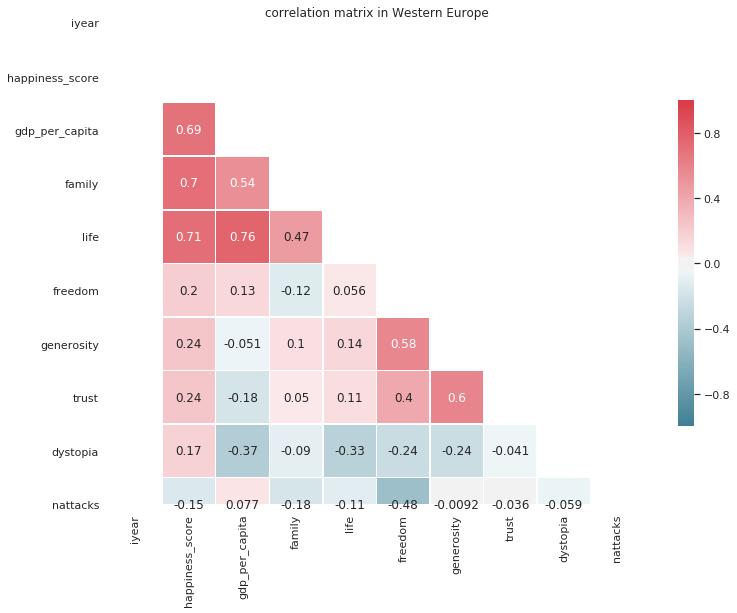

In [239]:
data = all_data[['iyear','country_code','happiness_score','gdp_per_capita','family','life','freedom','generosity','trust','dystopia','nattacks']]
corr = data[data.iyear.isin([2015])].corr()

import seaborn as sns
sns.set(style="white")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12,12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

plt.title(F'correlation matrix in Western Europe')

plt.show()